In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import pickle
import gc

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import matplotlib.patches as mpatches

In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [31]:
# Load adata 
adata_full=sc.read(path_data+'data_rawnorm_integrated_annotated.h5ad')
# Add correctly normalised X
adata_full.X=adata_full.layers['X_sf_integrated']
# Add metadata
adata_full.obs=sc.read(path_data+'data_integrated_analysed.h5ad',backed='r').obs.copy()
adata_full.uns=sc.read(path_data+'data_integrated_analysed.h5ad',backed='r').uns.copy()

In [10]:
marker_palette={'embryonic':'#B59749','postnatal':'#5790BA','both':'k'}

In [4]:
# Load De results
de_res=defaultdict(dict)
for stage,d,cts in [('P','celltypes',['alpha','beta','delta']),
                    ('E','celltypes_embryo',['Alpha','Beta','Delta'])]:
    for ct in cts:
        de_res[stage][ct.lower()]=pd.read_excel(
            path_data+d+'/DEedgeR_summaries_ctParsed.xlsx',sheet_name=ct,index_col=0)

## Marker summary comparison P vs E
For each postnatal and embryonic marker compare lFC (summarised across OvO DE tests as saved in the DE notebook) and mark which markers were significant in postnatal/embryo/both.

In [6]:
PADJ=0.05
LFC=1.5

In [61]:
# Extract markers
markers_plot=defaultdict(set)
for stage, res_sub in de_res.items():
    for ct,res_sub2 in res_sub.items():
        markers_plot[ct].update(res_sub2.query('padj<@PADJ & logFC>@LFC').index)

In [62]:
# Get is_marker and LFC data across cts and stages for marker genes
data_plot=[]
for ct,genes in markers_plot.items():
    for gene in genes:
        data_sub={'gene':gene,'cell type':ct}
        for stage in ['P','E']:
            if gene in de_res[stage][ct].index:
                lfc=de_res[stage][ct].at[gene,'logFC']
                marker=(de_res[stage][ct].at[gene,'logFC']>LFC) &\
                        (de_res[stage][ct].at[gene,'padj']<PADJ)
            else:
                lfc=0
                marker=False
            data_sub['marker_'+stage]=stage if marker else ''
            data_sub['logFC '+stage.replace('E','embryonic').replace('P','postnatal')]=lfc
        data_plot.append(data_sub)
data_plot=pd.DataFrame(data_plot)

# Is marker in both or only one stage
data_plot['marker']=pd.Categorical(
    values=data_plot.apply(lambda x:x.marker_E+x.marker_P, axis=1).replace(
        {'EP':'both','E':'embryonic','P':'postnatal'}),
    categories=['embryonic','postnatal','both'],ordered=True)

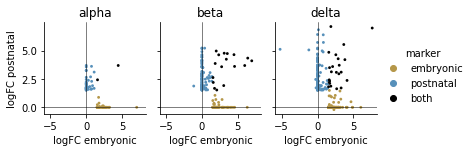

In [63]:
# Plot lFC and is marker comparison across stages for each ct
g=sb.relplot(x='logFC embryonic',y='logFC postnatal',col='cell type',hue='marker',
           data=data_plot,kind='scatter',height=2, aspect=0.85, s=8,
             palette=marker_palette,linewidth=0)
for ax in g.axes[0]:
    ax.axvline(0,c='k',lw=0.5)
    ax.axhline(0,c='k',lw=0.5)
    ax.set_title(ax.get_title().split('= ')[1])
    ax.set(facecolor = (0,0,0,0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.savefig(path_fig+'scatter_endoMarkers_logfcEvsP.png',dpi=300,bbox_inches='tight')

## Example Cer1 expression in embryo and postnatal
Cer1 is more highly expressed in E than P, but it is a marker only in P due to different cts present in E and P that also express it (e.g. in E, thus it is not delta-specific marker).

In [59]:
# Get Cer1 EID
eid=list(adata_full.var.query('gene_symbol=="Cer1"').index)
if len(eid)>1:
    raise ValueError('More than 1 EID')
else:
    eid=eid[0]

In [93]:
# Expression postnatal
cts=['acinar', 'alpha','beta', 'delta', 'ductal', 'endothelial', 'gamma', 'immune',
 'schwann','stellate_activated', 'stellate_quiescent']

expr_p=adata_full[(adata_full.obs.study!='embryo').values &
                  (adata_full.obs.cell_type_integrated_v1.isin(cts)),
                  eid].to_df()
expr_p['cell_type']=list(adata_full.obs.loc[expr_p.index,'cell_type_integrated_v1_parsed'].values)
expr_p['cell_type']=pd.Categorical(
    values=expr_p['cell_type'],ordered=True,
    categories=[c for c in adata_full.obs['cell_type_integrated_v1_parsed'].cat.categories
               if c in expr_p['cell_type'].values])
expr_p=expr_p.groupby('cell_type').mean()
expr_p['stage']='postnatal'

In [94]:
# Expression embryo
expr_e=adata_full[(adata_full.obs.study=='embryo').values &
                  (adata_full.obs.pre_cell_type!='NA'),
                  eid].to_df()
expr_e['cell_type']=list(adata_full.obs.loc[expr_e.index,'pre_cell_type'].values)
expr_e=expr_e.groupby('cell_type').mean()
expr_e['stage']='embryonic'

In [145]:
# Joint expression E and P
expr=pd.concat([expr_e,expr_p])
expr.index.name='cell type'

In [142]:
# Stage annotation for plot
stage_cmap={'embryonic':'#8a9e59','postnatal':'#c97fac'}
col_anno=expr['stage'].map(stage_cmap)

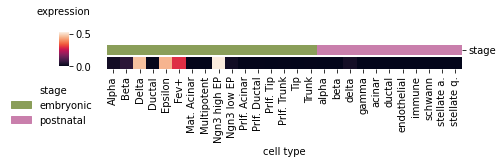

In [150]:
# Plot expression heatmap
# Sizes
h_colors=0.25
ncol=1*0.47
nrow=expr.shape[0]*0.25
w=ncol
h=nrow+h_colors
# Heatmap
g=sb.clustermap(pd.DataFrame(expr[eid]).T,xticklabels=True,yticklabels=False,
          col_colors=col_anno,
          row_cluster=False,col_cluster=False,
             figsize=(h,w),
             colors_ratio=(h_colors/h,w_colors/w),dendrogram_ratio=0.000001,
                cbar_pos=(0.1,0.2,0.02,1))

g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.ax_cbar.set_title('expression\n',fontsize=10)   

# Legend for stage
l=plt.legend(handles=\
             [mpatches.Patch(alpha=0, label='stage')]+
             [mpatches.Patch(color=c, label=l) 
                      for l,c in stage_cmap.items()],
          bbox_to_anchor=(4.2,-0.3))
l.get_frame().set_alpha(0)
plt.savefig(path_fig+'heatmap_atlas_ctExprEP_Cer1.png',dpi=300,bbox_inches='tight')

## Example markers expression across endo P and E clusters

In [38]:
# Make adata subset
# Make cts - postnatal annotated in atlas re-annotation, embryonic in original study annotation
cts_endo=['alpha','beta','delta','gamma','epsilon']
adata_full.obs['ct_plot']=[
    c+' P' if c in cts_endo and s!='embryo'  else np.nan
    for c,s in  zip(adata_full.obs.cell_type_integrated_v1,adata_full.obs.study) ]
embryo_cells=adata_full.obs_names[adata_full.obs.study=='embryo']
adata_full.obs.loc[embryo_cells,'ct_plot']=[
     c.lower()+' E'  if c.lower() in cts_endo else np.nan
     for c in  adata_full.obs.loc[embryo_cells,'pre_cell_type'] ]
adata_sub=adata_full[~adata_full.obs.ct_plot.isna(),:].copy()
# Get ct order and add epsilon as missing in atlas cts
ct_order=['alpha','beta','delta','epsilon','gamma']
adata_sub.obs['ct_plot']=pd.Categorical(
    values=adata_sub.obs['ct_plot'],ordered=True,
    categories=[c+' '+s for c in ct_order for s in ['E','P'] 
                if c+' '+s in adata_sub.obs['ct_plot'].unique()])

In [53]:
adata_sub.obs['ct_plot'].value_counts(sort=False)

alpha E        1422
alpha P       40903
beta E         1232
beta P       102109
delta E         103
delta P       24663
epsilon E       230
gamma P        6993
Name: ct_plot, dtype: int64

In [57]:
# markers
genes={'alpha\n(human)':['Irx2','Ttr','Gcg','Slc7a2'],
       'beta\n(human)':['Ins1', 'Ins2', 'G6pc2', 'Iapp'],
       'delta\n(human)':['Rbp4','Sst'],
       'gamma\n(human)':['Ppy'],
       'epsilon\n(human)':['Ghrl','Irs4'],
       'alpha\n(new)':['Wnk3', 'Nxph1', 
                       # 'Galnt13' #- not good marker in postnatal - also in gamma
                      ],
       'beta\n(new)':['Cytip', 'Spock2', 
                      # 'St8sia5' #- not good marker in postnatal and in generally lowly expressed
                     ],
       'delta\n(new)':['Slc2a3', 'Nrsn1', 'Spock3'],
       'gamma\n(new)':['Vsig1'],
      }
gene_gs_eid_map={g:list(adata_full.var.query('gene_symbol==@g').index)
                 for gs in genes.values() for g in gs}
for g,eid in gene_gs_eid_map.items():
    if len(eid)==1:
        gene_gs_eid_map[g]=eid[0]
    else:
        raise valueError('No exactly 1 EID for gene')

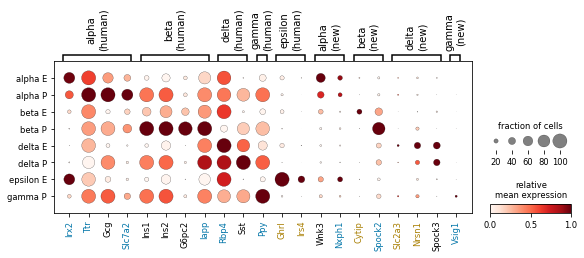

In [8]:
# Dotplot
dp=sc.pl.dotplot(adata_sub, var_names=genes,
                         gene_symbols='gene_symbol',use_raw=False,
              groupby='ct_plot',
              standard_scale='var',
                size_title='fraction of cells',
              colorbar_title='relative\nmean expression',
              show=False)

# Color by signif - in embryo/postnatal/both
ax=dp['mainplot_ax']
cts_plot=adata_sub.obs['ct_plot'].cat.categories
for ct in cts_endo:
    # get signif markers per ct, except if ct not present in taht stage
    if ct+' E' in cts_plot:
        signif_embryo=set(pd.read_excel(
            '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/celltypes_embryo/DEedgeR_summaries_ctParsed.xlsx', 
                                sheet_name=ct.capitalize(),index_col=0).query('logFC>1.5&padj<0.05').index)
    else:
        signif_embryo={}
    if ct+' P' in cts_plot:
        signif_postnatal=set(pd.read_excel(
            '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/celltypes/DEedgeR_summaries_ctParsed.xlsx', 
            sheet_name=ct,index_col=0).query('logFC>1.5&padj<0.05').index)
    else:
        signif_postnatal={}
    markers_ct=[g for group,gs in genes.items() for g in gs if group.startswith(ct)]
    for l in ax.get_xticklabels():
        g=l.get_text()
        if g in markers_ct:
            eid=gene_gs_eid_map[g]
            if eid in signif_embryo and eid in signif_postnatal:
                l.set_color('black')
            elif eid in signif_embryo:
                l.set_color('#A97F03')   
            elif eid in signif_postnatal:
                l.set_color('#0376A9')  
            else:
                raise ValueError('Missing gene in signif:',eid)
plt.savefig(path_fig+'dotplot_atlas_endoMarkers.png',dpi=300,
                bbox_inches='tight')